In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import ml_metrics
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
import itertools
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('cardox.csv')
data.head()

,date,value
0,1958-03-01,315.71
1,1958-04-01,317.45
2,1958-05-01,317.50
3,1958-06-01,317.10
4,1958-07-01,315.86


In [3]:
data.index = pd.to_datetime(data['date'], format = '%Y%m%')

In [4]:
del data['date']

In [5]:
data.tail()

,value
date,
2018-07-01,408.71
2018-08-01,406.99
2018-09-01,405.51
2018-10-01,406.00
2018-11-01,408.02


<AxesSubplot: xlabel='date'>

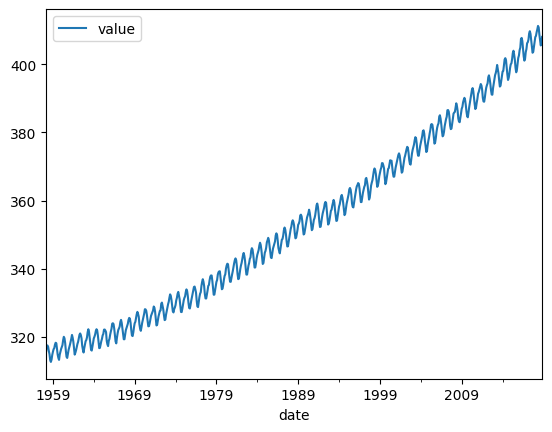

In [6]:
data.plot()

In [7]:
data.describe()

,value
count,729.000000
mean,353.787229
std,27.547500
min,312.660000
25%,328.570000
50%,351.410000
75%,375.990000
max,411.240000


In [8]:
data.isna().sum()

value    0
dtype: int64

In [9]:
def sesonal(data, s):
    plt.figure(figsize=(19,8), dpi= 80)
    for i, y in enumerate(data.index.year.unique()):
        plt.plot(list(range(1,len(data[data.index.year==y])+1)), data[data.index.year==y][data.columns[0]].values, label=y)
    plt.title("Сезонність по періодам")
    plt.show()

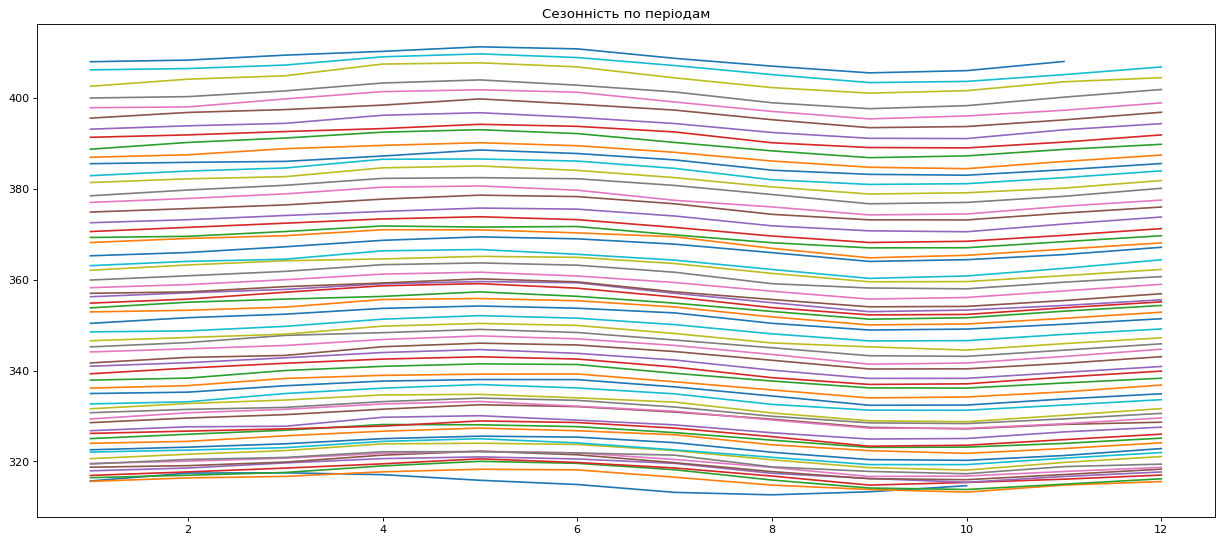

In [10]:
sesonal(data, 12)

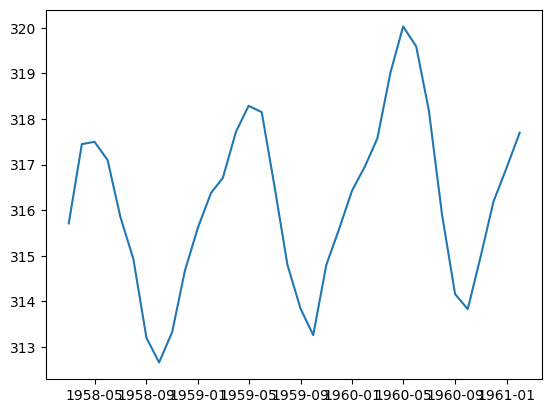

In [11]:
plt.plot(data[:36])

In [12]:
#аномалій в ряді не виявлено

In [13]:
decompose = seasonal_decompose(data, model = 'additive', extrapolate_trend=12)

Text(0.5, 0.98, 'additive model')

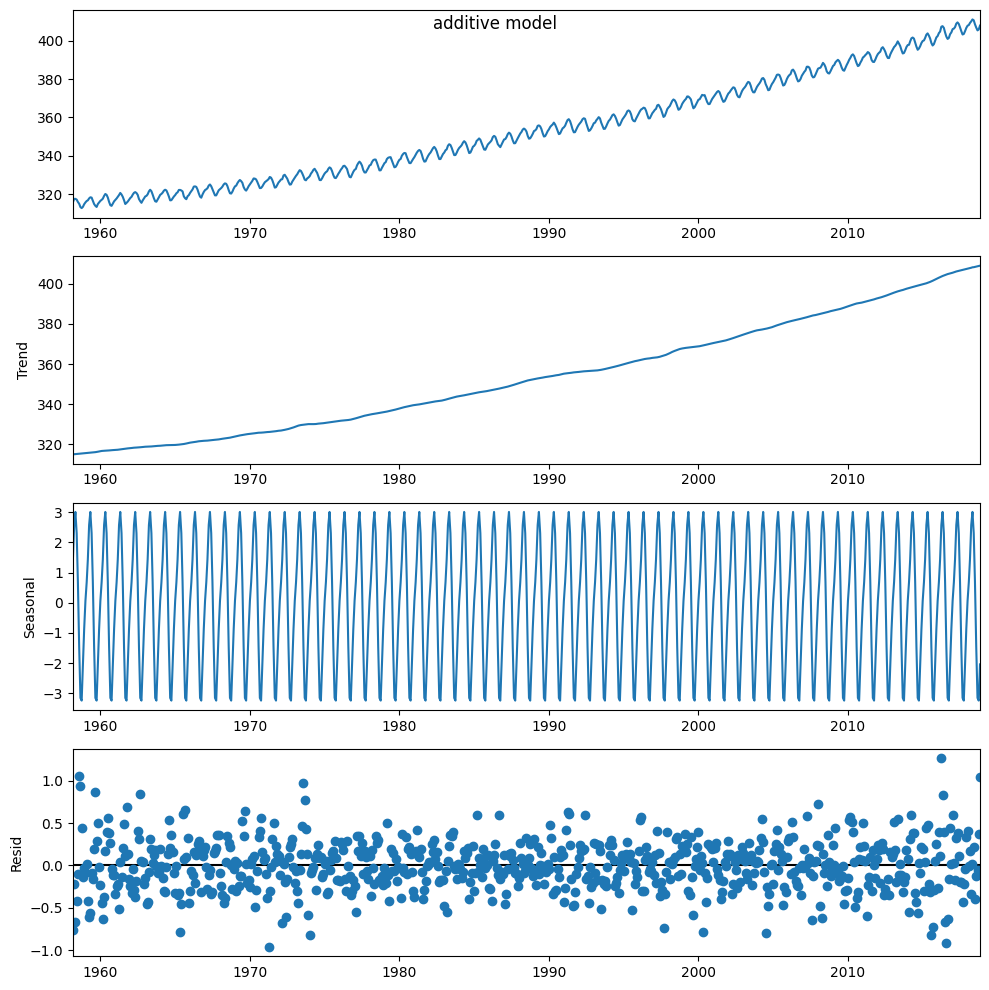

In [14]:
plt.rcParams.update({'figure.figsize': (10,10)})
decompose.plot().suptitle('additive model')

- При декомпозиції ряду виявлений тренд та сезонність, різких аномальних піків не виявлено - екзогенні фактори впливу відсутні. Сезонні зміни в даних залишаються приблизно однаковими з часом і не коливаються відносно загальних даних. 

In [15]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=12).mean() 
    rolstd = timeseries.rolling(window=12).std() 
    plt.rcParams["figure.figsize"] = (15,15)
    plt.plot(timeseries, color = 'green', label = 'true data')
    plt.plot(rolmean, color = 'red', label = 'rolling mean')
    plt.plot(rolstd, color = 'black', label = 'std')
    plt.show()

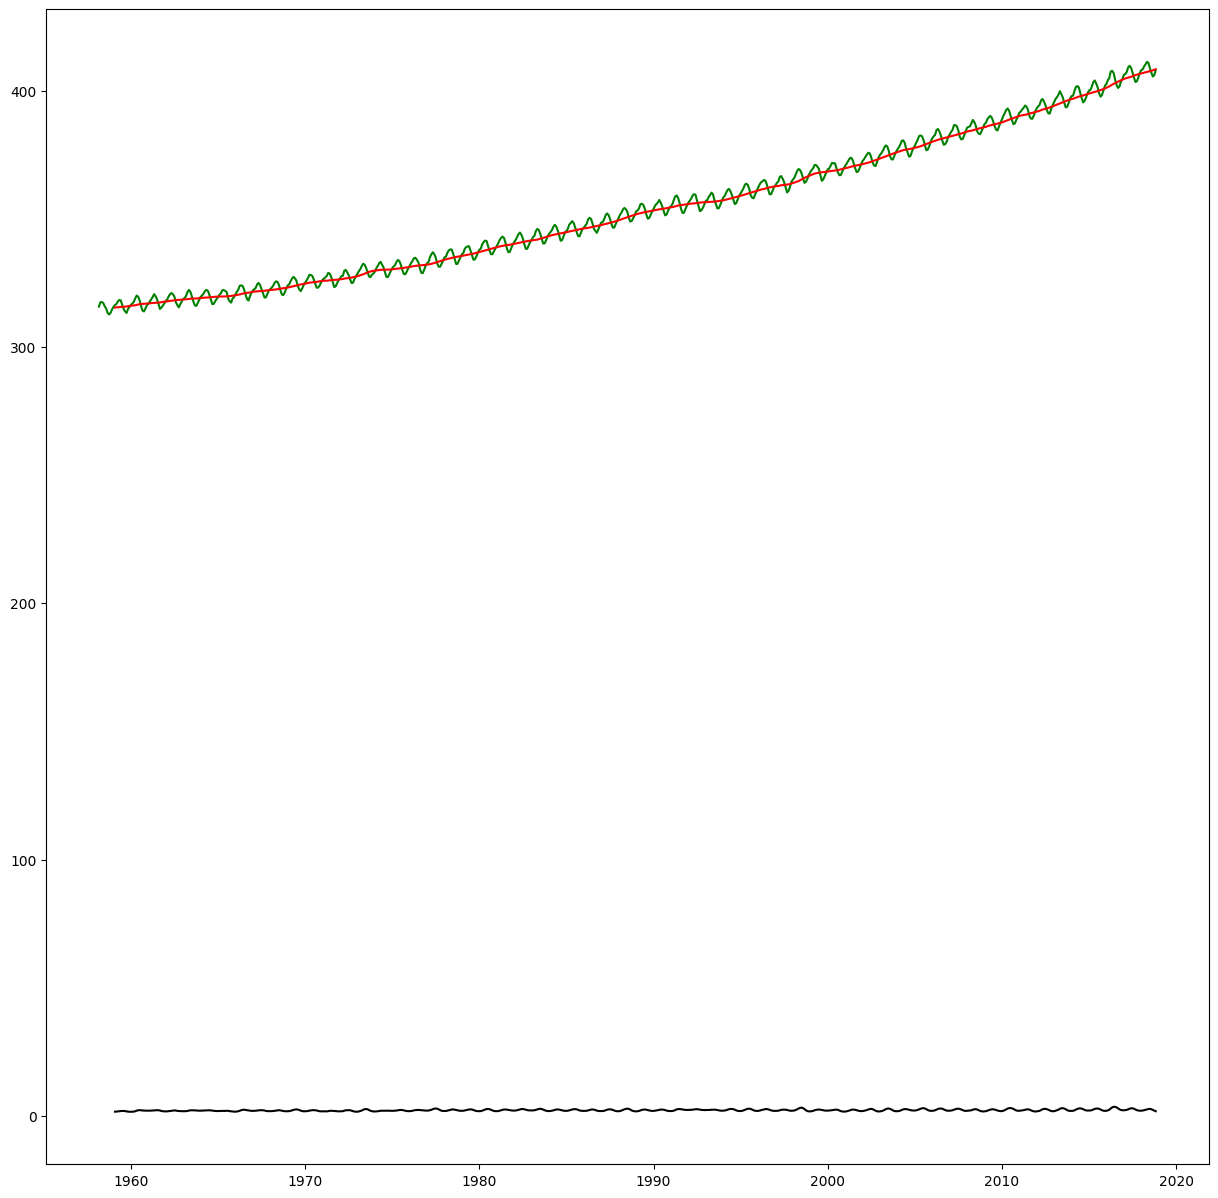

In [16]:
test_stationarity(data)

In [17]:
def test_s(data):
    test_stat = adfuller(data)
    if test_stat[0] < test_stat[4]['10%']:
        print(f"p-value {test_stat[1]}, critical values: {test_stat[4]},\n stationary time series")
    else:
        print(f"p-value {test_stat[1]}, critical values: {test_stat[4]}, \n NOT stationary time series")

In [18]:
test_s(data)

p-value 1.0, critical values: {'1%': -3.439620010600208, '5%': -2.8656309041017756, '10%': -2.5689484851894413}, 
 NOT stationary time series


- частота сезонності 12 місяців

In [19]:
train_data = data[:-20]
test_data = data[-20:]

______

In [20]:
fit_expo = HWES(train_data, seasonal_periods=12, trend = 'add', seasonal='add')

In [21]:
fitted = fit_expo.fit()

In [22]:
print(fitted.summary().tables[1])

                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.5647661                alpha                 True
smoothing_trend               0.0132979                 beta                 True
smoothing_seasonal            0.1059768                gamma                 True
initial_level                 314.66276                  l.0                 True
initial_trend                 0.0769198                  b.0                 True
initial_seasons.0             1.1362254                  s.0                 True
initial_seasons.1             2.2322081                  s.1                 True
initial_seasons.2             2.6283151                  s.2                 True
initial_seasons.3             2.0404341                  s.3                 True
initial_seasons.4             0.6242444                  s.4                 True
initial_seasons.

In [23]:
sales_forecast = fitted.forecast(steps=20)

In [24]:
date_range = pd.date_range(train_data.index[-1], periods = 380, freq = 'M')

In [25]:
sales_forecast_new = fitted.forecast(steps=len(date_range))

In [26]:
d = {'predict':sales_forecast_new}
predicted_data = pd.DataFrame(data = d)

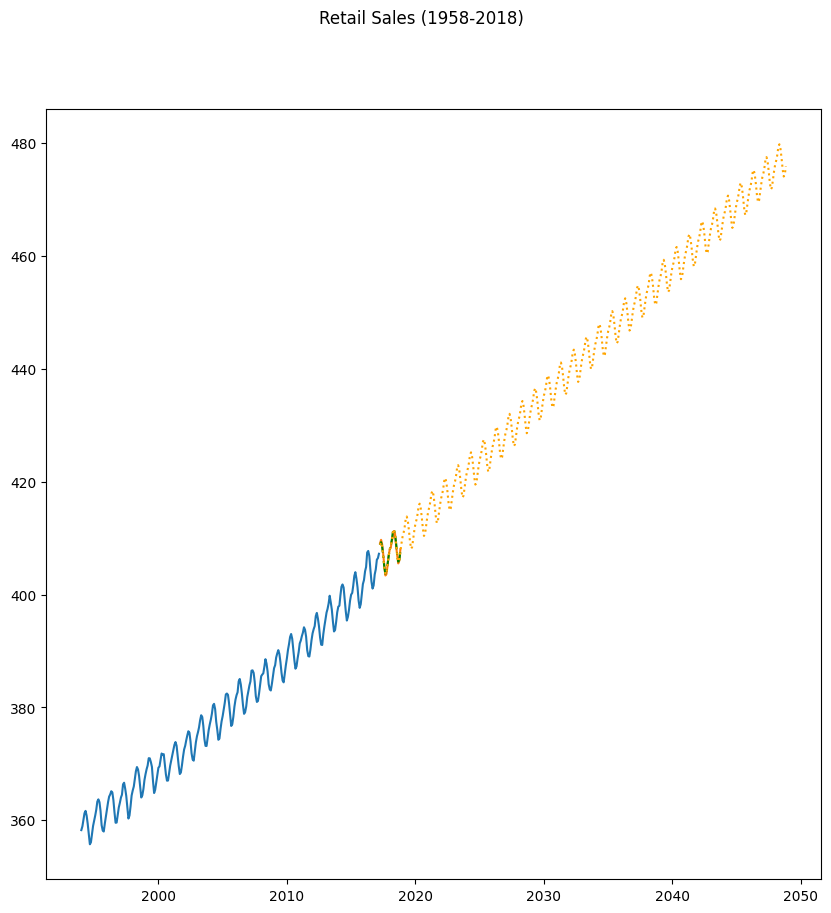

In [27]:
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Retail Sales (1958-2018)')
past = plt.plot(train_data.index[430:], train_data[430:], label='Sales History')
future = plt.plot(test_data.index, test_data)
predicted_test = plt.plot(test_data.index, sales_forecast, linestyle='-.', color = 'green')
predicted_values = plt.plot(predicted_data.index, sales_forecast_new, color = 'orange', linestyle=':')
plt.show()

In [28]:
def metrics(real, forecast):
    
    if type(real)==pd.core.frame.DataFrame:
        real=real[real.columns[0]].values
    
    print("Тест на стаціонарність:")
    dftest = adfuller(real-forecast, autolag='AIC')
    print("\tT-статистика = {:.3f}".format(dftest[0]))
    print("\tP-значення = {:.3f}".format(dftest[1]))
    print("Критичне значення :")
    for k, v in dftest[4].items():
        print("\t{}: {} - Дані {} стационарні з ймовірністю {}% відсотків".format(k, v, "не" if v<dftest[0] else "", 100-int(k[:-1])))
    
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартна похибка:', round(((real-forecast)**2).mean()**0.5,4)) 

In [29]:
metrics(test_data, sales_forecast)

Тест на стаціонарність:
	T-статистика = -0.051
	P-значення = 0.954
Критичне значення :
	1%: -4.223238279489106 - Дані не стационарні з ймовірністю 99% відсотків
	5%: -3.189368925619835 - Дані не стационарні з ймовірністю 95% відсотків
	10%: -2.729839421487603 - Дані не стационарні з ймовірністю 90% відсотків
MAD: 0.2757
MSE: 0.1065
MAPE: 0.0007
MPE: -0.0002
Стандартна похибка: 0.3263


____

In [30]:
from pmdarima.arima import auto_arima

In [31]:
arima_model = auto_arima(train_data, seasonal=True, m=12, trace=True, suppress_warnings=True, error_action='ignore')

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=442.490, Time=2.23 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2299.251, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1567.080, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2305.104, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=1.90 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=741.181, Time=2.13 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=485.796, Time=4.43 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=484.871, Time=4.14 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1396.151, Time=0.43 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=3.85 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=588.846, Time=4.26 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=472.355, Time=5.64 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=444.696, Time=1.86 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AI

In [32]:
model_sarima = sm.tsa.statespace.SARIMAX(train_data, order=(2, 1, 1), seasonal_order=(1, 0, 1, 12))

In [33]:
result_sarima = model_sarima.fit()

In [34]:
print(result_sarima.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3562      0.085      4.183      0.000       0.189       0.523
ar.L2          0.0883      0.039      2.292      0.022       0.013       0.164
ma.L1         -0.7095      0.084     -8.480      0.000      -0.873      -0.545
ar.S.L12       0.9996      0.000   2997.858      0.000       0.999       1.000
ma.S.L12      -0.8672      0.022    -38.612      0.000      -0.911      -0.823
sigma2         0.0960      0.005     20.026      0.000       0.087       0.105


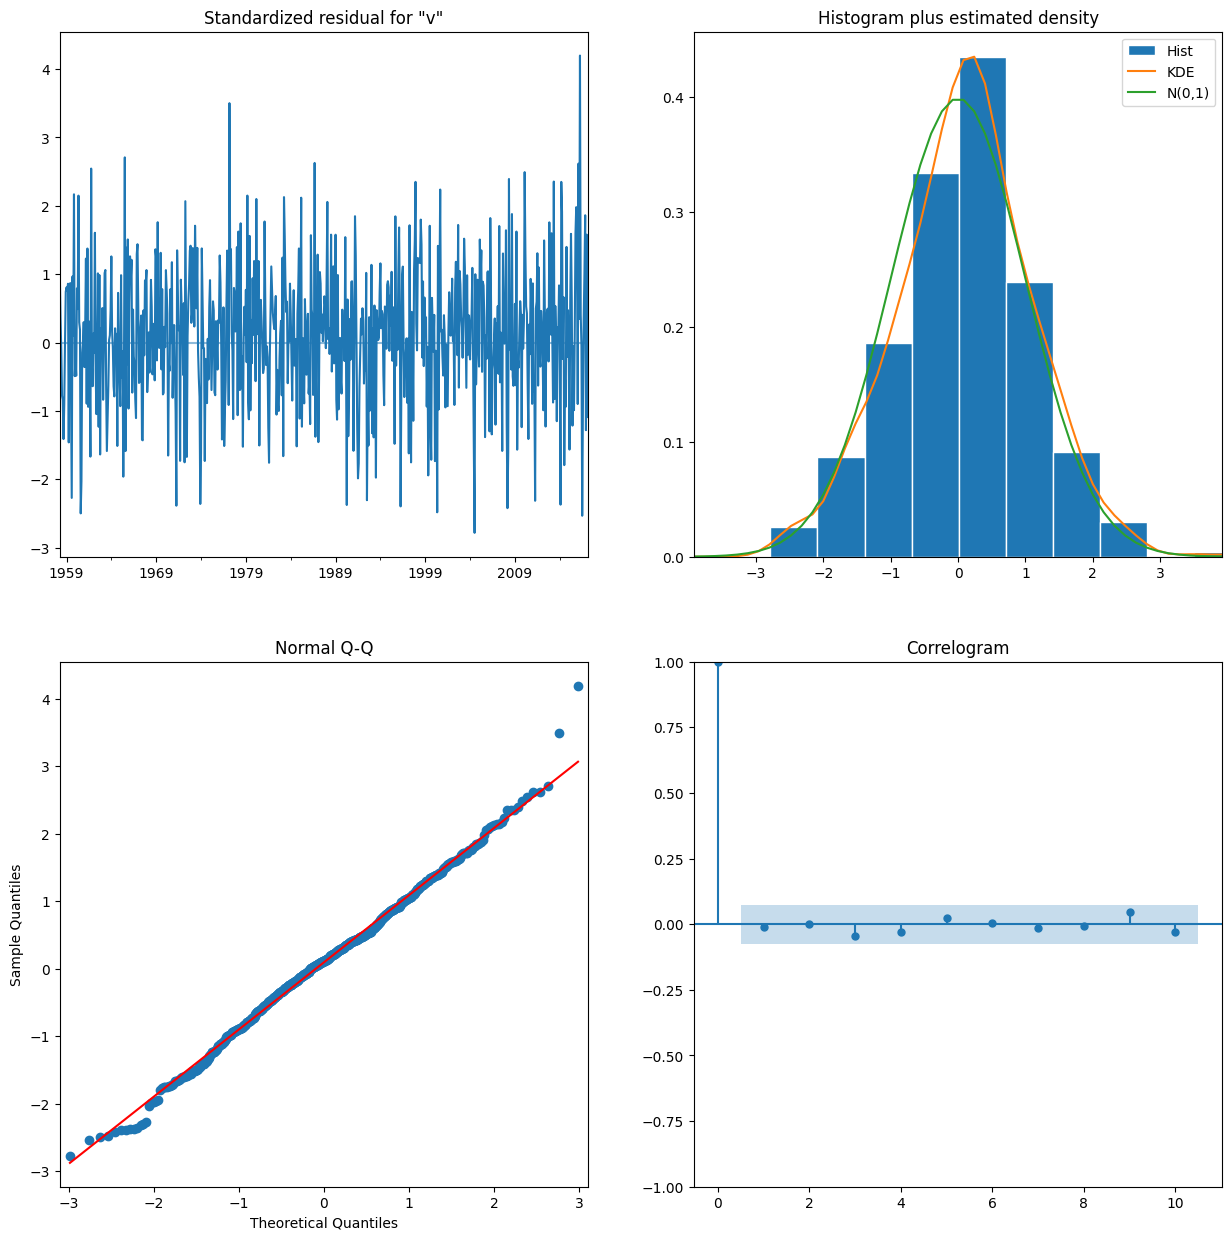

In [35]:
result_sarima.plot_diagnostics()
plt.show()

In [36]:
predicted = result_sarima.predict()
pred = result_sarima.get_prediction()
pred_df = pred.summary_frame()

In [37]:
pred_df.head()

value,mean,mean_se,mean_ci_lower,mean_ci_upper
1958-03-01,0.000000,1000.001391,-1959.966711,1959.966711
1958-04-01,315.709737,1.667989,312.440538,318.978937
1958-05-01,316.929687,1.591697,313.810019,320.049356
1958-06-01,317.277245,1.580506,314.179510,320.374980
1958-07-01,317.085109,1.574991,313.998183,320.172035


In [38]:
test_data.head()

,value
date,
2017-04-01,409.04
2017-05-01,409.69
2017-06-01,408.88
2017-07-01,407.12
2017-08-01,405.13


In [39]:
predict_new=result_sarima.get_prediction(start='2018', end='2048')

In [40]:
predict_test = result_sarima.get_prediction(start='2017-04', end='2018-11')

In [41]:
metrics(test_data, predict_test.predicted_mean)

Тест на стаціонарність:
	T-статистика = -2.166
	P-значення = 0.219
Критичне значення :
	1%: -4.223238279489106 - Дані не стационарні з ймовірністю 99% відсотків
	5%: -3.189368925619835 - Дані не стационарні з ймовірністю 95% відсотків
	10%: -2.729839421487603 - Дані не стационарні з ймовірністю 90% відсотків
MAD: 0.2469
MSE: 0.1005
MAPE: 0.0006
MPE: -0.0002
Стандартна похибка: 0.317


In [42]:
predict_new.predicted_mean

2018-01-01    407.924508
2018-02-01    408.670550
2018-03-01    409.575459
2018-04-01    411.101388
2018-05-01    411.699178
                 ...    
2047-09-01    470.441733
2047-10-01    470.709933
2047-11-01    472.233478
2047-12-01    473.644243
2048-01-01    474.832907
Freq: MS, Name: predicted_mean, Length: 361, dtype: float64

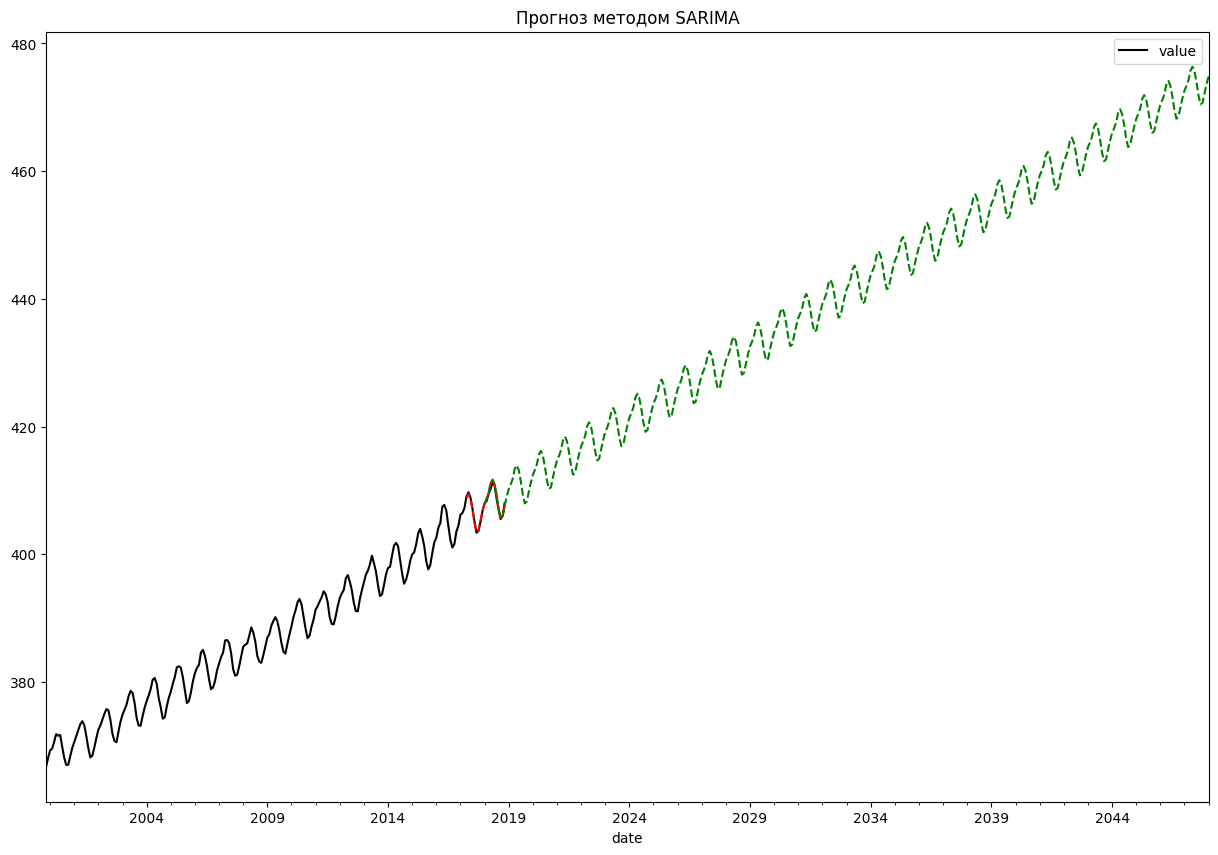

In [44]:
ax = data[500:].plot(figsize=(15,10), color='black', title="Прогноз методом SARIMA" )
predict_test.predicted_mean.plot(ax=ax, style='--', color='red')
predict_new.predicted_mean.plot(ax=ax, style='--', color='green')
plt.show()

In [45]:
forecast_d = {'predict' : predict_new.predicted_mean}
forecast_df = pd.DataFrame(data = forecast_d)

In [46]:
from pathlib import Path  
path = Path('C:/Users/akim5/OneDrive/Робочий стіл/ds_homeworks/homework_46, time series/forecast_shop.csv')

forecast_df.to_csv(path)